# Federated Learining - TBD

[Link to Colab (deprecated)](https://colab.research.google.com/drive/1GmAhxnKVvrhWffospDEe0rc-QB_tjfhE?usp=sharing)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pathlib import Path

from src.custom_types import TypeEnum
from src.tf_layer_constructors import (
    gen_normalization_layer,
    gen_multihot_categorical_encoding_layer
)
from src.tf_utils import df_to_tfds
from src.data_examples.ex1_data_loader import ExampleDataLoader

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


In [2]:
RAND_SEED = 1337

np.random.seed(RAND_SEED)
random.seed(RAND_SEED)
np.set_printoptions(precision=3, suppress=True)

tf.keras.backend.clear_session()

In [3]:
saved_model_path = Path('saved_models')
saved_model_path.mkdir(exist_ok=True)

## Loading Example Data

In [4]:
data = ExampleDataLoader()

data.download().load().clean()
data.df.info()

using cached file cache\static\public\10\automobile.zip
extracting zip file content:
 	size: 144	filename: Index
 	size: 1197	filename: app.css
 	size: 25936	filename: imports-85.data
 	size: 4747	filename: imports-85.names
 	size: 3757	filename: misc
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 3 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          159 non-null    int32  
 1   normalized_losses  159 non-null    float32
 2   make               159 non-null    string 
 3   fuel_type          159 non-null    string 
 4   aspiration         159 non-null    string 
 5   num_of_doors       159 non-null    string 
 6   body_style         159 non-null    string 
 7   drive_wheels       159 non-null    string 
 8   engine_location    159 non-null    string 
 9   wheel_base         159 non-null    float32
 10  length             159 non-null    float32
 11  width         

In [5]:
data.df['symboling_threshold'] = [1 if i > 0 else 0 for i in data.df['symboling']]

target_feature_label = 'symboling_threshold'

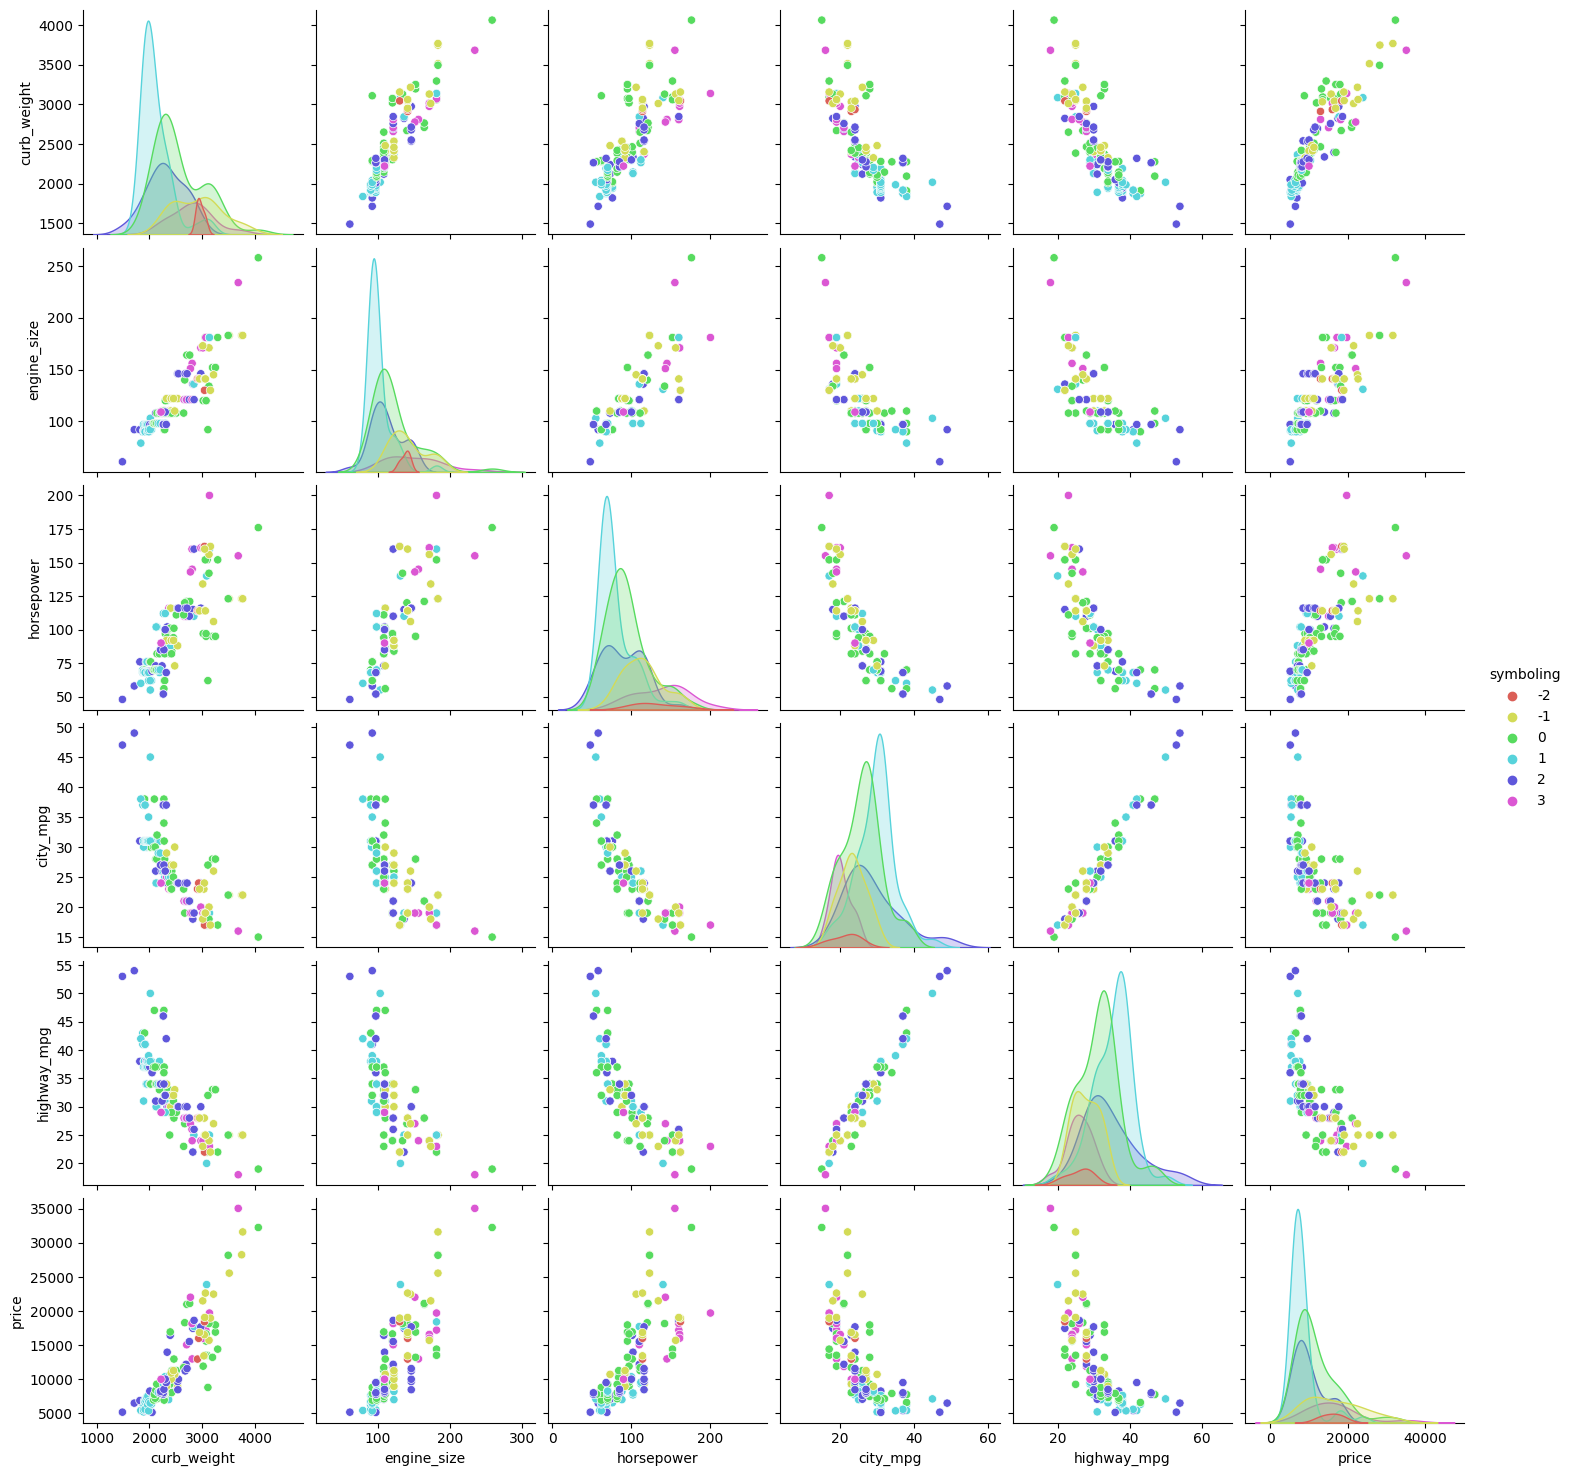

In [6]:
sns.pairplot(
  data.df[[
    data.feature_label,
    "curb_weight",
    "engine_size",
    "horsepower",
    # "peak_rpm",
    "city_mpg",
    "highway_mpg",
    "price"
  ]], diag_kind='kde', hue=data.feature_label, palette=sns.color_palette('hls', len(data.df[data.feature_label].unique())))

In [7]:
def generate_random_sample_from_spec(data_spec, features_override=[]):
  ret = {}
  for k in data_spec.keys():
    if features_override and k not in features_override:
      continue
    v = data_spec.get(k)
    if isinstance(v, tuple):
      ret[k] = random.random() * (v[1] - v[0])
    elif isinstance(v, list):
      ret[k] = random.choice(v)
    else:
      ret[k] = v
  return ret

In [8]:
__inference_sample_spec = list(map(lambda x: x.replace('_', '-'), data.features_categorical + data.features_numeric_continuous))
__inference_sample = generate_random_sample_from_spec(data.data_spec, __inference_sample_spec)
inference_sample = {}
for k, v in __inference_sample.items():
  inference_sample[k.replace('-', '_')] = tf.convert_to_tensor([v])

inference_sample

{'make': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'toyota'], dtype=object)>,
 'fuel_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'gas'], dtype=object)>,
 'aspiration': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'std'], dtype=object)>,
 'num_of_doors': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'two'], dtype=object)>,
 'body_style': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'hatchback'], dtype=object)>,
 'drive_wheels': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'rwd'], dtype=object)>,
 'engine_location': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'rear'], dtype=object)>,
 'wheel_base': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([31.615], dtype=float32)>,
 'length': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([20.611], dtype=float32)>,
 'width': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([11.907], dtype=float32)>,
 'height': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.459], dtype=floa

## 1. Centralized (Conventional) Training 

In [9]:
n_epoch = 25
batch_size = 24

ex1ch1_model_path = saved_model_path / 'ex1ch1_auto_classifier'

In [10]:
df_train = data.df.sample(frac=0.8, random_state=RAND_SEED)
df_val_test = data.df.drop(df_train.index)
df_test = df_val_test.sample(frac=0.5, random_state=RAND_SEED)
df_val = df_val_test.drop(df_test.index)

tfds_train  = df_to_tfds(df_train, target_feature_label, batch_size=batch_size, )
tfds_test   = df_to_tfds(df_test,  target_feature_label, batch_size=batch_size, )
tfds_val    = df_to_tfds(df_val,   target_feature_label, batch_size=batch_size, )

df_train.shape, df_test.shape, df_val.shape

c:\Users\62896\Documents\GitHub\FederatedLearning\src\tf_utils.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_df = {key: value[:,tf.newaxis] for key, value in df.items()}
c:\Users\62896\Documents\GitHub\FederatedLearning\src\tf_utils.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_df = {key: value[:,tf.newaxis] for key, value in df.items()}


((127, 27), (16, 27), (16, 27))

In [11]:
# size_df_all = data.df.shape[0]

# frac_train  = .8
# frac_test   = .1
# # remainder will be used as validation set

# size_train  = int(frac_train * size_df_all)
# size_test   = int(frac_test * size_df_all)

# tfds_all = df_to_tfds(data.df, target_feature_label, batch_size=batch_size, shuffle=True)

# tfds_train  = tfds_all.take(size_train)
# tfds_val    = tfds_all.skip(size_train).take(size_train)
# tfds_test   = tfds_val.skip(size_test)
# tfds_val    = tfds_test.take(size_test)
# print(list(tfds_val.batch(1).take(1).as_numpy_iterator()))

In [12]:
all_inputs = {}
all_encoded_features = {}

In [13]:
all_inputs['normalization'] = {}
all_encoded_features['normalization'] = {}

for col_name in data.features_numeric_continuous:

  input_numeric = tf.keras.Input(shape=(1,), name=col_name, dtype='float32')
  normalization_layer = gen_normalization_layer(tfds_train, col_name)
  encoded_normalized_input = normalization_layer(input_numeric)

  all_inputs['normalization'][col_name] = input_numeric
  all_encoded_features['normalization'][col_name] = encoded_normalized_input

In [14]:
all_inputs['categorical'] = {}
all_encoded_features['categorical'] = {}

for col_name in data.features_categorical:
  input_categorical = tf.keras.Input(shape=(1,), name=col_name, dtype='string')
  categorical_encoder = gen_multihot_categorical_encoding_layer(tfds_train, col_name, TypeEnum.string, max_tokens=5)
  encoded_categorical_input = categorical_encoder(input_categorical)

  all_inputs['categorical'][col_name] = input_categorical
  all_encoded_features['categorical'][col_name] = encoded_categorical_input

In [15]:
all_inputs

{'normalization': {'wheel_base': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'wheel_base')>,
  'length': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'length')>,
  'width': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'width')>,
  'height': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'height')>,
  'curb_weight': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'curb_weight')>,
  'engine_size': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'engine_size')>,
  'bore': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bore')>,
  'stroke': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'stroke')>,
  'compression_ratio': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'compression_ratio')>,
  'horsepower': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'horsepower')>,
  'peak_rpm': <KerasTensor: shape=(None, 1) dtype=float32 (created by l

In [16]:
def build_categorical_model(input_layers, feature_layers):
  nn_dense = tf.keras.layers.Dense(32, activation='relu')(feature_layers)
  nn_dense = tf.keras.layers.Dropout(0.5)(nn_dense)
  output = tf.keras.layers.Dense(1)(nn_dense)
  return tf.keras.Model(input_layers, output)


In [17]:
all_inputs_layers = [j for i in all_inputs.values() for j in i.values()]
all_features = [j for i in all_encoded_features.values() for j in i.values()]
all_feature_layers = tf.keras.layers.concatenate(all_features)

x = tf.keras.layers.Dense(64, activation="relu")(all_feature_layers)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs_layers, output)
all_features

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_3')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_4')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_5')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_6')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_7')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_8')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_9')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_10')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization

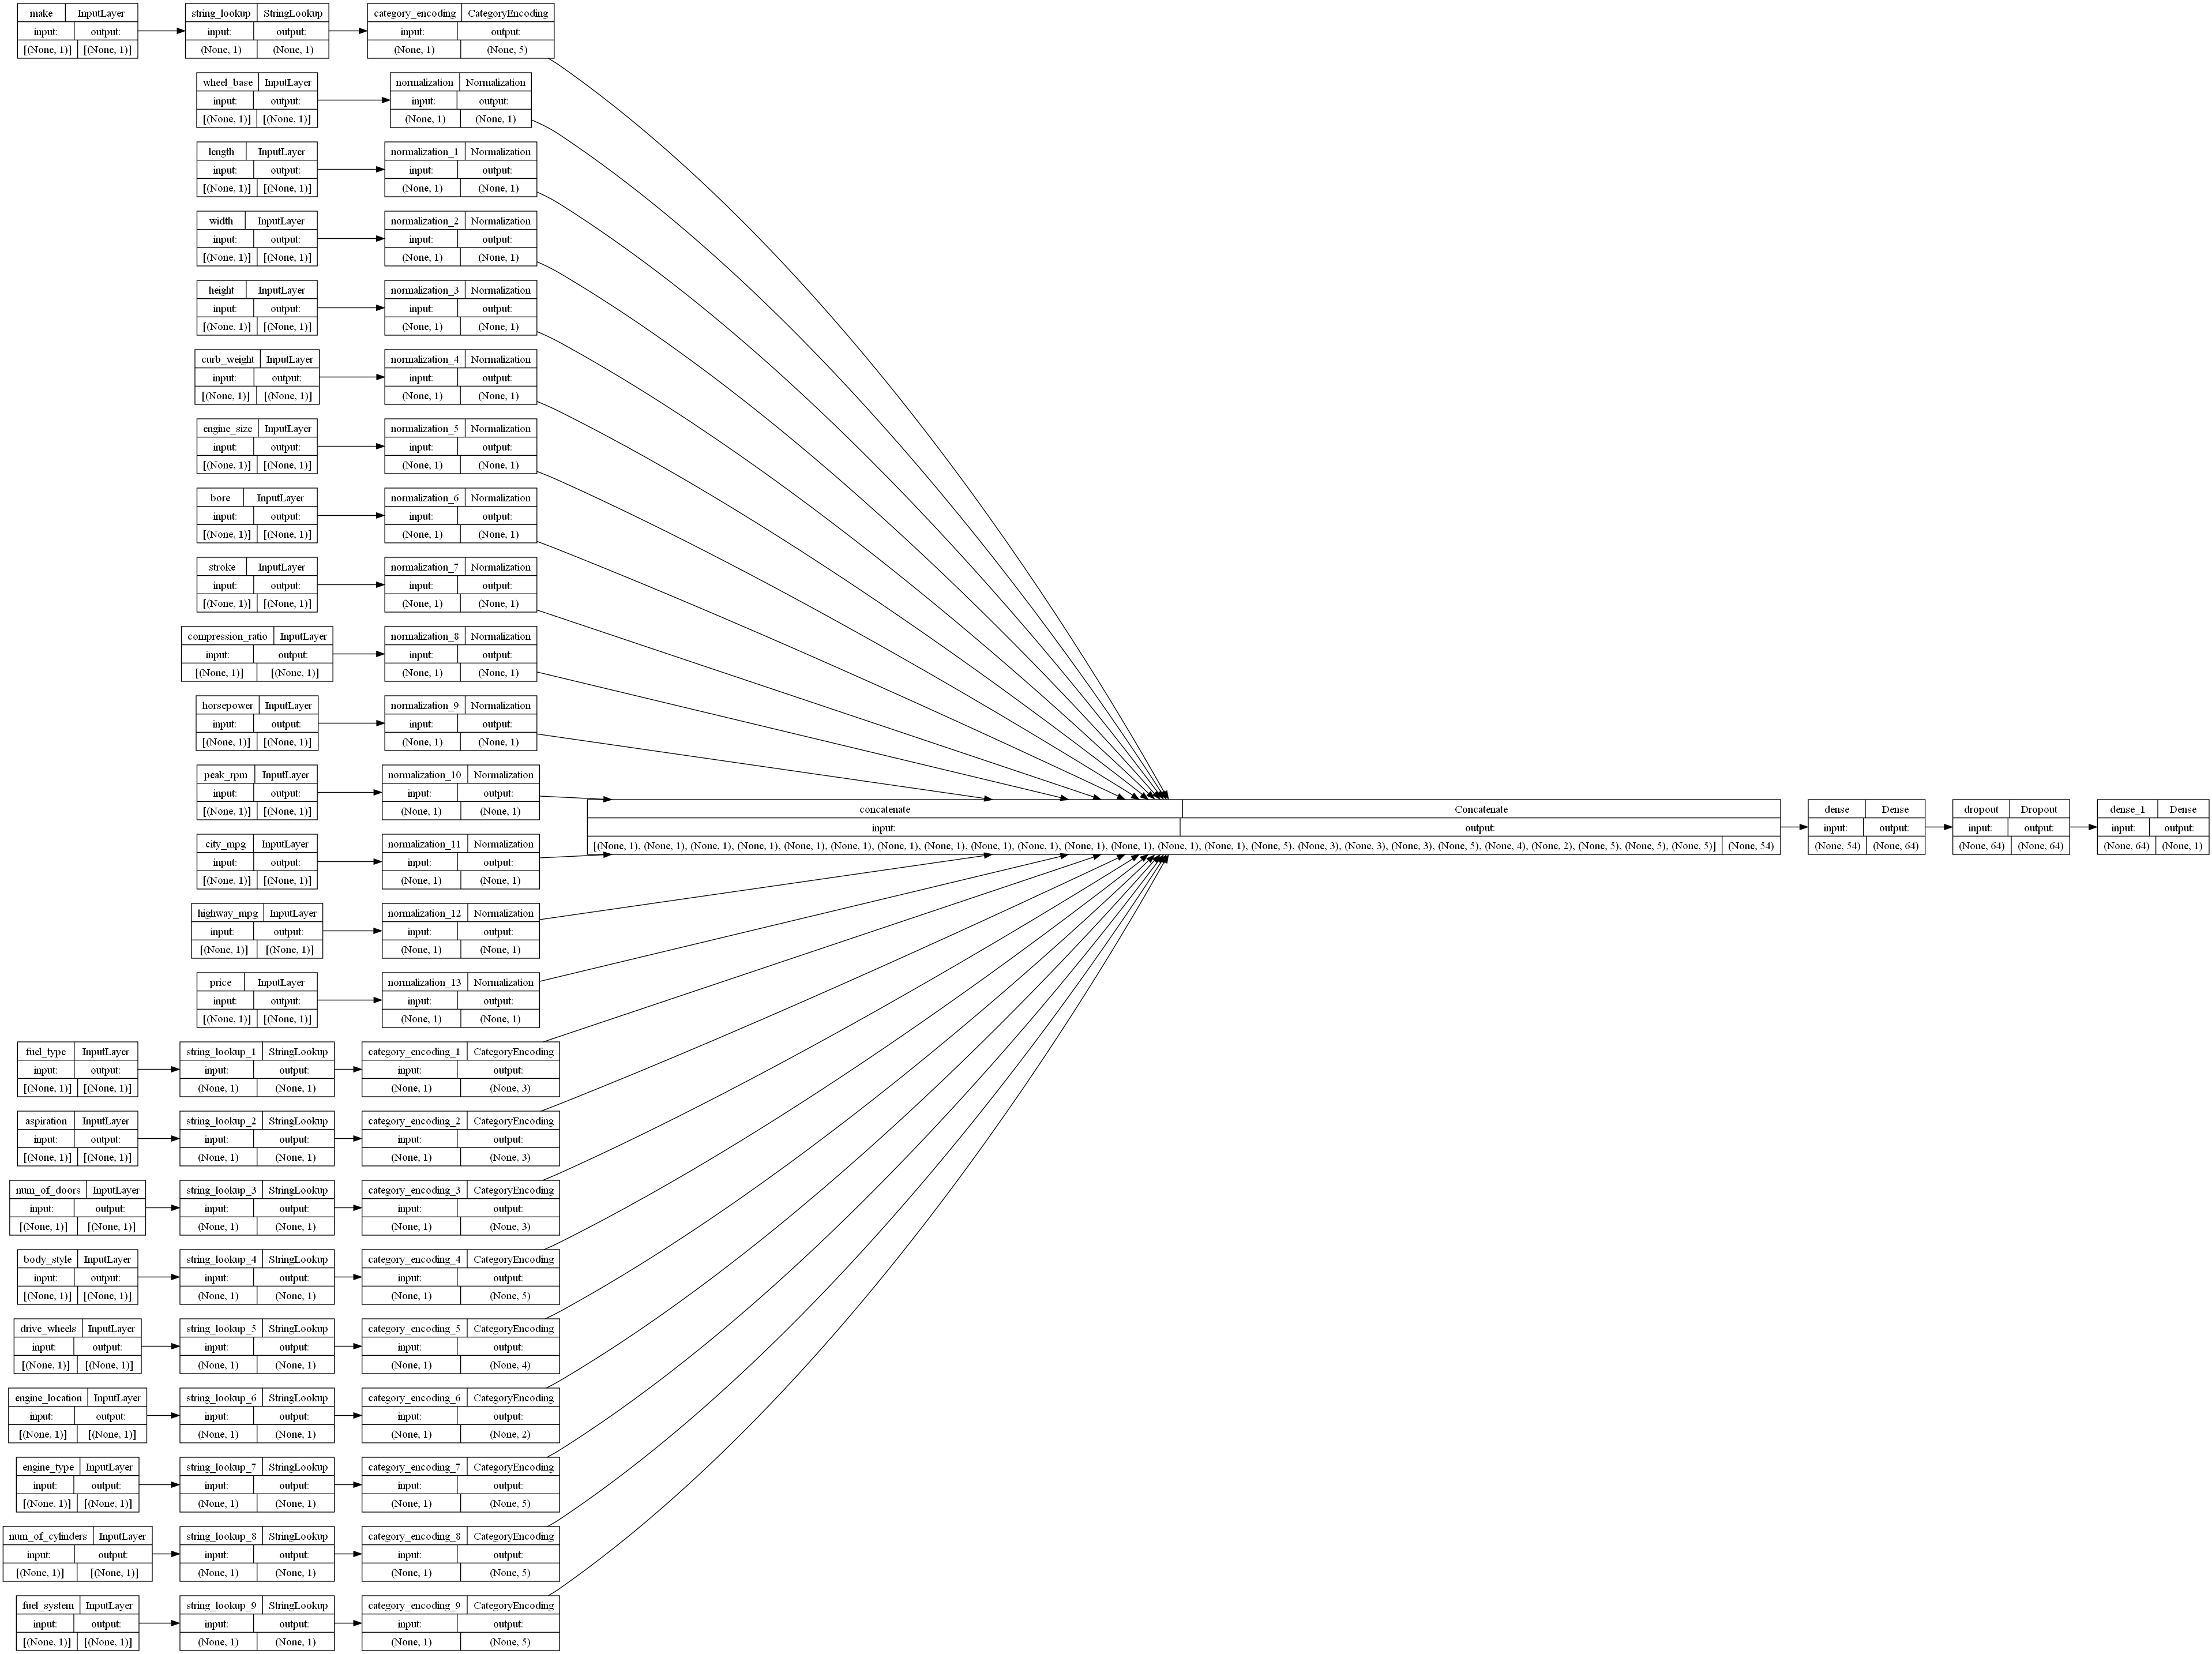

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [19]:
model.fit(tfds_train, epochs=n_epoch, validation_data=tfds_val)

Epoch 1/25


C:\Users\62896\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py:639: UserWarning: Input dict contained keys ['symboling', 'normalized_losses', 'symboling_threshold'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


6/6 [==============================] - 3s 182ms/step - loss: 6.9969 - accuracy: 0.4567 - val_loss: 9.9446 - val_accuracy: 0.1875
Epoch 2/25
6/6 [==============================] - 0s 11ms/step - loss: 6.5950 - accuracy: 0.4252 - val_loss: 5.8028 - val_accuracy: 0.2500
Epoch 3/25
6/6 [==============================] - 0s 12ms/step - loss: 4.4814 - accuracy: 0.4567 - val_loss: 2.8981 - val_accuracy: 0.3125
Epoch 4/25
6/6 [==============================] - 0s 11ms/step - loss: 5.2376 - accuracy: 0.4882 - val_loss: 2.4286 - val_accuracy: 0.6250
Epoch 5/25
6/6 [==============================] - 0s 12ms/step - loss: 4.1508 - accuracy: 0.5276 - val_loss: 2.2617 - val_accuracy: 0.6875
Epoch 6/25
6/6 [==============================] - 0s 12ms/step - loss: 3.1362 - accuracy: 0.5906 - val_loss: 2.1833 - val_accuracy: 0.6875
Epoch 7/25
6/6 [==============================] - 0s 12ms/step - loss: 4.1738 - accuracy: 0.5669 - val_loss: 2.1364 - val_accuracy: 0.6875
Epoch 8/25
6/6 [=====================

In [20]:
loss, accuracy = model.evaluate(tfds_test)
print("Accuracy", accuracy)
model.save(ex1ch1_model_path)

1/1 [==============================] - 0s 44ms/step - loss: 1.0941 - accuracy: 0.8750
Accuracy 0.875


INFO:tensorflow:Assets written to: saved_models\ex1ch1_auto_classifier\assets


INFO:tensorflow:Assets written to: saved_models\ex1ch1_auto_classifier\assets


In [21]:
loaded_model = tf.keras.models.load_model(ex1ch1_model_path)
predictions = loaded_model.predict(inference_sample)
predictions

1/1 [==============================] - 1s 933ms/step


array([[0.868]], dtype=float32)